<a href="https://colab.research.google.com/github/Fjoru/TM10007_PROJECT/blob/Gonnie/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment Prediction of tumor grade in brain cancer
By Jessica Barends, Gonnie van Erp, Erik Kemper en Carlijn Oerlemans

In [1]:
# Run install for use in colab environment
!pip install --upgrade pip
!pip install -q --upgrade git+https://github.com/Fjoru/TM10007_PROJECT
!pip install ipdb -q
!pip install seaborn
!pip install tensorflow

     |████████████████████████████████| 1.4MB 4.7MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


## Import section


In [2]:
import ipdb
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# import tensorflow as tf

# Preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Feature selection
import umap
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

# Classifiers
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import model_selection

# Classifiers used in random search
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

# Evaluation metrics used
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## preprocessing

In [0]:
def Replace(i):
    if isinstance(i, int):
          return i
    try:
        float(i)
        return float(i)
    except:
        return np.nan

def preprocessing_steps(X_design, Y_design, X_test, Y_test):
    # training set
    # remove strings from data
    X_design = X_design.applymap(func=Replace)

    # set 0.0 as NaN
    X_design.replace(0, np.nan, inplace=True)

    # set Inf as NaN
    X_design.replace([np.inf, -np.inf], np.nan, inplace=True)

    # remove features with less than 60% values
    X_design = X_design.dropna(thresh=round(X_design.shape[0]*0.6), axis='columns')

    # remove sample with less than 60% values
    # join features and labels
    XY_design = X_design.join(Y_design)
    # remove samples with not enough values
    XY_design = XY_design.dropna(thresh=round(XY_design.shape[1]*0.6))

    # remove samples without a label
    XY_design['label'].replace(np.nan, '', inplace=True)
    XY_design = XY_design[XY_design['label'].astype(bool)]

    # split features (X_data) and labels (Y_data)
    X_design = XY_design.drop(columns=['label'])
    Y_design = XY_design[['label']]
    
    # add missing value's 
    imputer = IterativeImputer(sample_posterior=True, n_nearest_features=20, random_state=0)
    X_design_imputed = imputer.fit_transform(X_design)

    # normalization of values
    scaler = RobustScaler()
    X_design_scaled = scaler.fit_transform(X_design_imputed)

    # getting back to Dataframe 
    X_design = pd.DataFrame(X_design_scaled, columns=X_design.columns, index=X_design.index)

    ####### test set
    # remove strings from data
    X_test = X_test.applymap(func=Replace)

    # set 0.0 as NaN
    X_test.replace(0, np.nan, inplace=True)

    # set Inf as NaN
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # remove the same features as the design set
    features_design = X_design.columns
    features_design = X_design.columns
    
    df_test = None
    for feature in features_design:
      df_test_single = pd.DataFrame(X_test[feature])
      if df_test is None:
        df_test = df_test_single
      else:
        df_test = df_test.join(df_test_single, how='outer')
    
    X_test = df_test
    
    # remove sample with less than 60% values
    # join features and labels
    XY_test = X_test.join(Y_test)
    # remove samples with not enough values
    XY_test = XY_test.dropna(thresh=round(XY_test.shape[1]*0.6))

    # remove samples without a label
    XY_test['label'].replace(np.nan, '', inplace=True)
    XY_test = XY_test[XY_test['label'].astype(bool)]

    # split features (X_test) and labels (Y_test)
    X_test = XY_test.drop(columns=['label'])
    Y_test = XY_test[['label']]
    
    # add missing value's 
    X_test_imputed = imputer.transform(X_test)

    # normalization of values
    X_test_scaled = scaler.transform(X_test_imputed)

    # getting back to Dataframe 
    X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    return X_design, Y_design, X_test, Y_test

## Feature selection and extraction

In [0]:

def feature_steps(X_design, Y_design):
    '''
    Feature steps Hyperparameters:
    Feature selection:
    - estimator type
      - optional kernel
    - RFECV
      - steps
      - minimal numb of features
      - CV type
      - number of splits
      - scoring method
    Feature extraction:
    - estimator type
    - UMAP
      - numb of resulting features
      - numb of used neighbors
      - type of distance calculation
      - minimal distance
    '''

    # *Design set*
    # Feature selection
    
    # Create SVC model
    #svc = svm.SVC(kernel="linear") 
  
    # Create RFE object
    #rfecv = RFECV(
    #    estimator=svc, step=1, min_features_to_select=1, 
    #    cv=model_selection.StratifiedKFold(n_splits=6), # number of CV steps
    #    scoring='roc_auc')                              # type of scoring

    # Preform cross-validation     
    #X_design = rfecv.fit_transform(X_design, Y_design)
    
    # Plot number of features VS. cross-validation scores
    #plt.figure()
    #plt.xlabel("Number of features selected")
    #plt.ylabel("Cross validation score (nb of correct classifications)")
    #plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    #plt.show()
    
    # Feature extraction
    
    # Create UMAP model
    # Docs on umap: https://umap-learn.readthedocs.io/en/latest/index.html
    Umapper = umap.UMAP(n_neighbors=15, n_components=2)

    # Preform model fitting and transformation
    X_design = Umapper.fit_transform(X_design)
    X_design = pd.DataFrame(X_design, index=Y_design.index)

    # *Test Set*
    # Feature selection
    #X_test = rfecv.transform(X_test)

    # Feature extraction

    # preform model transsformation
    #X_test = Umapper.transform(X_test)
    #X_test = pd.DataFrame(X_test, index=Y_test.index)

    # Visualize Feature extraction
    # make label set binary
    Y_design_bin = Y_design.replace(['GBM', 'LGG'], [1, 0])

    # combine data and labels
    #df = pd.DataFrame(data=X_design, index=Y_design_bin.index)
    #df = df.join(Y_design_bin)

    # generate pairplot
    #pp = sns.pairplot(df[:], hue='label', size=1.8, aspect=1.8, 
    #                  palette={0: "#9966FF", 1: "#FFE888"},
    #                  plot_kws=dict(edgecolor="black", linewidth=0.5))
    #fig = pp.fig 
    #fig.subplots_adjust(top=0.93, wspace=0.3)
    #t = fig.suptitle('Feature Attributes Pairwise Plots', fontsize=14)

    return X_design, Y_design, Y_design_bin

## Classifiers


In [5]:
 def classifiers (X_design, Y_design, X_test, Y_test):
    global results
    global best_parameters
   
    ## Example for Classifier hyperparameters selecting
    clfs = {svm.SVC(probability=True): {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': range(1,5,1)},
            RandomForestClassifier(): {'n_estimators':range(1,400,5)},
            KNeighborsClassifier() : {'n_neighbors': range(1,100,2), 'weights': ['uniform', 'distance']},
            LinearDiscriminantAnalysis():{}
            }
    names = ['SVC', 'RandomForest', 'KNN', 'LinearDiscriminant']
    n = 0
    for clf, parameters in clfs.items():
        scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'f1-score': make_scorer(f1_score)}

        random_search = RandomizedSearchCV(clf, parameters, scoring=scoring, refit='AUC', cv=None) ## hierin zit al de crossvalidatie, dus opnieuw een k-fold split hoeft niet #keuze om score voor alle classifiers gelijk te houden of per classifier te definieren
        random_search.fit(X_design, Y_design)

        # Get resulting classifier
        clf_best = random_search.best_estimator_
        print(f'Best classifier: parameters={random_search.best_params_}')
        best_parameters.append(random_search.best_params_)   #per fold best classifier will be appended

        # Test the classifier on the test data
        # prob = clf_best.predict_proba(X_test)
        # scores = prob[:, 1]

      	# Gettin accuracy, AUC and f1-score
        #accuracy = accuracy_score(Y_test, scores)
        #auc = metrics.roc_auc_score(Y_test, scores)
        #f1 = f1_score(Y_test, scores)
        #results.append({
            #'accuracy': accuracy,
            #'AUC': auc,
            #'f1-score': f1,
            #'clf': clf,
            #'parameters': random_search.best_params_,
            #'set': 'test'
            #})

        # Test the classifier on the training data
        prob_testing = clf_best.predict(X_design)
        scores_training = prob_testing

        if n == 0:
          clf_name = names[0]
        elif n % 4 == 1:
          clf_name = names[1]
        elif n % 4 == 2:
          clf_name = names[2]
        elif n % 4 == 3:
          clf_name = names[3]
        elif n % 4 == 0:
          clf_name = names[0]
        n += 1 
    
        # Getting the accuracy, AUC and f1-score
        accuracy = accuracy_score(Y_design, scores_training)
        auc = roc_auc_score(Y_design, scores_training)
        f1 = f1_score(Y_design, scores_training)
        results.append({
            'accuracy': accuracy,
            'AUC': auc,
            'f1-score': f1,
            'clf': clf_name,
            'parameters': random_search.best_params_,
            'set': 'training'
              })

    # Create results dataframe and plot it
    results = pd.DataFrame(results)
    sns.boxplot(y='AUC', x='clf', data=results)
    sns.boxplot(y='accuracy', x='clf', data=results)
    sns.boxplot(y='f1-score', x='clf', data=results)

    #optimal_parameters = int(np.median(best_parameters))
    #print(f"The optimal parameters={optimal_parameters}")
    
    return results

ERROR! Session/line number was not unique in database. History logging moved to new session 60


## Run Pipeline

run all predefined steps

The number of samples: 167
The number of columns: 725
              VOLUME_ET  VOLUME_NET  ...  TGM_Cog_Z_1   TGM_T_1
ID                                   ...                       
TCGA-02-0064   0.306650   -0.149335  ...    -0.409811  0.412749
TCGA-02-0068  -0.131777   -0.098523  ...    -0.254765 -0.182429
TCGA-02-0069  -0.006484    0.912666  ...     0.284368  2.705034
TCGA-02-0070  -0.274249   -0.314443  ...     0.839935 -0.449039
TCGA-02-0075  -0.109278    0.247846  ...     0.451606 -0.017942
...                 ...         ...  ...          ...       ...
TCGA-HT-8018  -0.506682   -0.179239  ...    -0.849962 -0.833459
TCGA-HT-8111  -0.512206   -0.381408  ...     1.026131 -0.804997
TCGA-HT-8114  -0.282298    3.740634  ...     0.526592 -0.757509
TCGA-HT-8563  -0.181188   -0.367314  ...    -0.466627 -0.801878
TCGA-HT-A61A   0.757504    1.082333  ...    -0.592295  0.330073

[150 rows x 698 columns]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Best classifier: parameters={'kernel': 'rbf', 'degree': 2}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

Best classifier: parameters={'n_estimators': 201}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

Best classifier: parameters={'weights': 'distance', 'n_neighbors': 17}
Best classifier: parameters={}


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


   accuracy       AUC  ...                                  parameters       set
0  0.780000  0.741199  ...              {'kernel': 'rbf', 'degree': 2}  training
1  1.000000  1.000000  ...                       {'n_estimators': 201}  training
2  1.000000  1.000000  ...  {'weights': 'distance', 'n_neighbors': 17}  training
3  0.766667  0.733191  ...                                          {}  training

[4 rows x 6 columns]


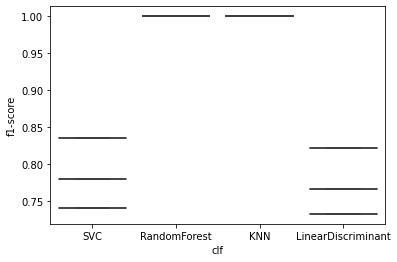

In [6]:
# Data loading functions.
from brats.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
data = pd.DataFrame(data)

# split labels and values
data_X = data.drop(columns=['label'])
data_Y = data[['label']]

# data split index forming
Test_split = model_selection.StratifiedKFold(n_splits=10)
results = list()
best_parameters = list()

i = 0
for design_index, test_index in Test_split.split(data_X, data_Y):
    if i:
      continue
    X_design = data_X.iloc[design_index]
    Y_design = data_Y.iloc[design_index]
    
    X_test = data_X.iloc[test_index]
    Y_test = data_Y.iloc[test_index]

    # run preprocessing step
    X_design, Y_design, X_test, Y_test = preprocessing_steps(X_design, Y_design, X_test, Y_test)
    print(X_design)
    
    #run feature selection and extraction
    X_design, Y_design, Y_design_bin = feature_steps(X_design, Y_design)
    i = 1

    results = classifiers (X_design, Y_design_bin, X_test, Y_test)
    print (results)
   

# save data to csv for manual check
#X_design.to_csv('data_X.csv')
#Y_design.to_csv('data_Y.csv')

